# Распознователь цифр

Digit Recognizer - https://www.kaggle.com/c/digit-recognizer

# Импорты

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn import tree

import warnings

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Вспомогательные функции

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [4]:
def plot_digit(digit, dem = 28, font_size = 12):
    max_ax = font_size * dem
    
    fig = plt.figure(figsize=(13, 13))
    plt.xlim([0, max_ax])
    plt.ylim([0, max_ax])
    plt.axis('off')
    black = '#000000'
    
    for idx in range(dem):
        for jdx in range(dem):

            t = plt.text(idx * font_size, max_ax - jdx*font_size, digit[jdx][idx], fontsize = font_size, color = black)
            c = digit[jdx][idx] / 255.
            t.set_bbox(dict(facecolor=(c, c, c), alpha = 0.5, edgecolor = 'black'))
            
    plt.show()

# Подготовка данных

Загружаем датасеты

In [39]:
train = pd.read_csv("../content/drive/MyDrive/Machine/digit_train.csv")
test = pd.read_csv("../content/drive/MyDrive/Machine/digit_test.csv")

In [6]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Проверяем на наличие пустых значений

In [ ]:
train.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [ ]:
test.isnull().sum()

pixel0      0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 784, dtype: int64

Отделяем целевые данные

In [40]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"],axis = 1) 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


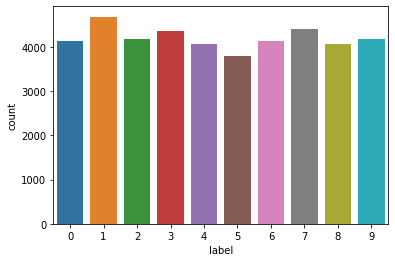

In [ ]:
sns.countplot(Y_train)

Нормализуем данные. Максимальный оттенок пикселя это 255.

In [41]:
X_train = X_train / 255.0
test = test / 255.0

In [42]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

Перекодируем категориальные признаки

In [43]:
Y_train = to_categorical(Y_train, num_classes = 10)

Разбиваем данные на обучающие и тестовые

In [37]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1)

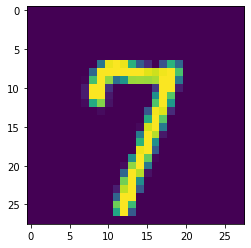

In [ ]:
g = plt.imshow(X_train[3][:,:,0])

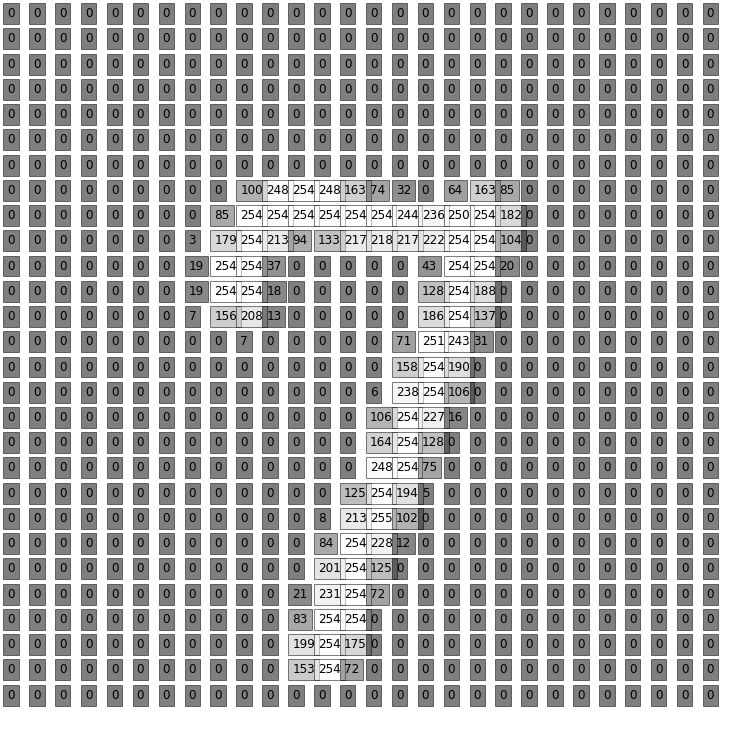

In [ ]:
plot_digit(X_train[3][:,:,0])

# Модель NB

In [ ]:
parameters = {'var_smoothing': np.logspace(0,-9, num=100)}
nb = GridSearchCV(GaussianNB(), parameters).fit(X_train, Y_train)
nb.best_params_

{'var_smoothing': 0.0657933224657568}

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       411
           1       0.77      0.96      0.86       485
           2       0.92      0.75      0.83       403
           3       0.81      0.75      0.78       418
           4       0.86      0.63      0.73       461
           5       0.85      0.59      0.70       372
           6       0.83      0.91      0.87       413
           7       0.94      0.77      0.85       446
           8       0.63      0.76      0.69       382
           9       0.58      0.88      0.70       409

    accuracy                           0.79      4200
   macro avg       0.81      0.79      0.79      4200
weighted avg       0.81      0.79      0.79      4200



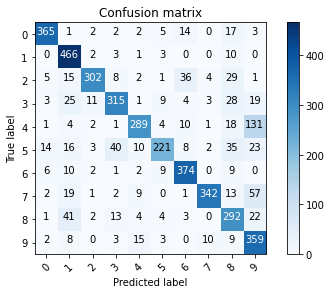

In [ ]:
nb_clf = nb.best_estimator_
nb_y_pred = nb_clf.predict(X_val)
print(classification_report(Y_val, nb_y_pred))
nb_confusion_mtx = confusion_matrix(Y_val, nb_y_pred)
plot_confusion_matrix(nb_confusion_mtx, classes = range(10))

# Модель DTC

In [ ]:
parameters = {'max_leaf_nodes': range(2, 100), 'min_samples_split': [2, 3, 4]}
dtc = GridSearchCV(tree.DecisionTreeClassifier(), parameters).fit(X_train, Y_train)
dtc.best_params_

{'max_leaf_nodes': 99, 'min_samples_split': 2}

              precision    recall  f1-score   support

           0       0.89      0.93      0.91       411
           1       0.93      0.94      0.94       485
           2       0.84      0.81      0.82       403
           3       0.83      0.78      0.81       418
           4       0.85      0.86      0.85       461
           5       0.77      0.76      0.77       372
           6       0.88      0.88      0.88       413
           7       0.91      0.89      0.90       446
           8       0.73      0.80      0.76       382
           9       0.82      0.81      0.81       409

    accuracy                           0.85      4200
   macro avg       0.85      0.84      0.84      4200
weighted avg       0.85      0.85      0.85      4200



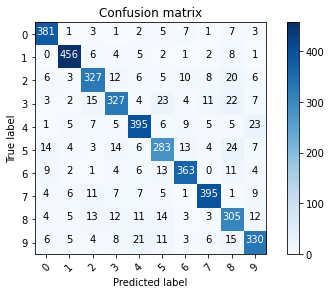

In [ ]:
dtc_clf = dtc.best_estimator_
dtc_y_pred = dtc_clf.predict(X_val)
print(classification_report(Y_val, dtc_y_pred))
dtc_confusion_mtx = confusion_matrix(Y_val, dtc_y_pred)
plot_confusion_matrix(dtc_confusion_mtx, classes = range(10))

# Модель SVM

In [38]:
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
svc = GridSearchCV(svm.SVC(), parameters).fit(X_train, Y_train)
svc.best_params_

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       411
           1       0.99      0.99      0.99       485
           2       0.98      0.98      0.98       403
           3       0.97      0.96      0.97       418
           4       0.98      0.98      0.98       461
           5       0.97      0.97      0.97       372
           6       0.97      0.99      0.98       413
           7       0.99      0.96      0.98       446
           8       0.96      0.96      0.96       382
           9       0.97      0.96      0.96       409

    accuracy                           0.97      4200
   macro avg       0.97      0.97      0.97      4200
weighted avg       0.97      0.97      0.97      4200



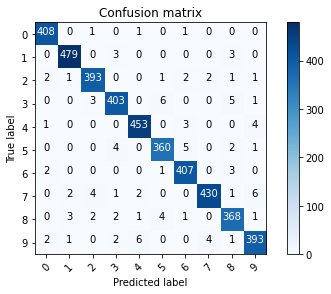

In [ ]:
svc_clf = dtc.best_estimator_
svc_y_pred = svc_clf.predict(X_val)
print(classification_report(Y_val, svc_y_pred))
svc_confusion_mtx = confusion_matrix(Y_val, svc_y_pred)
plot_confusion_matrix(svc_confusion_mtx, classes = range(10))

# Модель нейронной сети

In [12]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

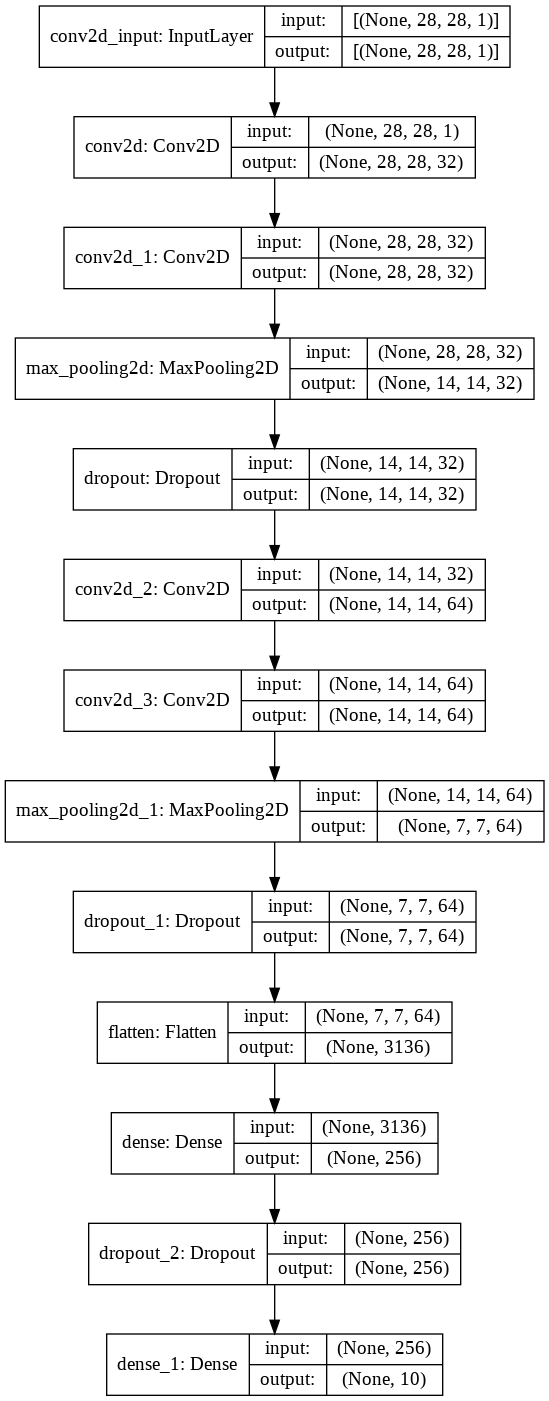

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [ ]:
model.fit(X_train, Y_train, epochs=30)

Epoch 1/30
1182/1182 [==============================] - 272s 229ms/step - loss: 0.4479 - accuracy: 0.8509
Epoch 2/30
1182/1182 [==============================] - 264s 224ms/step - loss: 0.0790 - accuracy: 0.9755
Epoch 3/30
1182/1182 [==============================] - 264s 224ms/step - loss: 0.0610 - accuracy: 0.9819
Epoch 4/30
1182/1182 [==============================] - 261s 221ms/step - loss: 0.0515 - accuracy: 0.9833
Epoch 5/30
1182/1182 [==============================] - 264s 224ms/step - loss: 0.0391 - accuracy: 0.9885
Epoch 6/30
1182/1182 [==============================] - 265s 224ms/step - loss: 0.0387 - accuracy: 0.9887
Epoch 7/30
1182/1182 [==============================] - 264s 223ms/step - loss: 0.0312 - accuracy: 0.9904
Epoch 8/30
1182/1182 [==============================] - 262s 222ms/step - loss: 0.0305 - accuracy: 0.9905
Epoch 9/30
1182/1182 [==============================] - 264s 223ms/step - loss: 0.0286 - accuracy: 0.9911
Epoch 10/30
1182/1182 [=======================

## Cохранение и загрузка модели

In [ ]:
model.save('../content/drive/MyDrive/Machine/c_model_1')

INFO:tensorflow:Assets written to: ../content/drive/MyDrive/Machine/c_model_1/assets


In [13]:
model = load_model('../content/drive/MyDrive/Machine/c_model_1')

## Оценка модели

In [ ]:
_ , accuracy = model.evaluate(X_val, Y_val)
print('Accuracy: %.4f' % (accuracy*100))

132/132 [==============================] - 7s 54ms/step - loss: 0.0389 - accuracy: 0.9933
Accuracy: 99.3333


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       411
           1       1.00      1.00      1.00       485
           2       0.99      1.00      0.99       403
           3       1.00      0.99      0.99       418
           4       0.99      0.99      0.99       461
           5       0.99      0.99      0.99       372
           6       0.99      0.99      0.99       413
           7       1.00      1.00      1.00       446
           8       0.98      1.00      0.99       382
           9       0.99      0.98      0.98       409

    accuracy                           0.99      4200
   macro avg       0.99      0.99      0.99      4200
weighted avg       0.99      0.99      0.99      4200



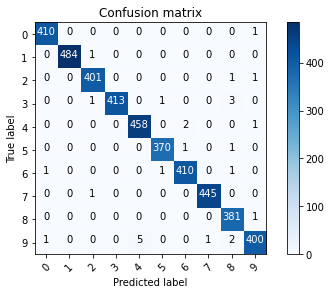

In [16]:

Y_val =np.argmax(Y_val, axis=-1)
y_pr = model.predict(X_val)
y_pr = np.argmax(y_pr, axis=-1)
print(classification_report(Y_val, y_pr))
svc_confusion_mtx = confusion_matrix(Y_val, y_pr)
plot_confusion_matrix(svc_confusion_mtx, classes = range(10))

## Поиск изображений с ошибками и просмотр некоторых из них

In [17]:
errors = []
for i in range(0, 4200):
  if(Y_val[i] != y_pr[i]):
    errors.append(i);

In [18]:
errors

[331,
 404,
 526,
 664,
 665,
 725,
 1446,
 1842,
 1893,
 2120,
 2271,
 2429,
 2492,
 2614,
 2620,
 2763,
 2890,
 3052,
 3152,
 3234,
 3326,
 3475,
 3556,
 3677,
 3780,
 3881,
 3917,
 4199]

True 9
Predicted 7


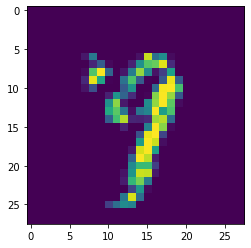

In [27]:
print("True", Y_val[331])
print("Predicted", y_pr[331])
plt.imshow(X_val[331][:,:,0])

True 8
Predicted 9


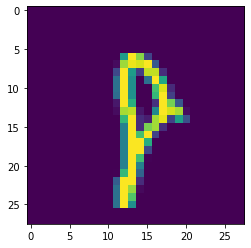

In [26]:
print("True", Y_val[404])
print("Predicted", y_pr[404])
plt.imshow(X_val[404][:,:,0])

True 5
Predicted 8


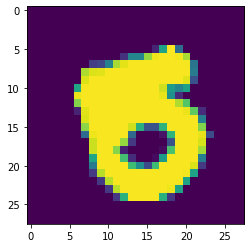

In [28]:
print("True", Y_val[526])
print("Predicted", y_pr[526])
plt.imshow(X_val[526][:,:,0])

True 4
Predicted 9


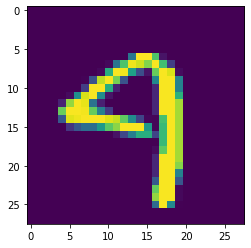

In [29]:
print("True", Y_val[664])
print("Predicted", y_pr[664])
plt.imshow(X_val[664][:,:,0])

True 9
Predicted 8


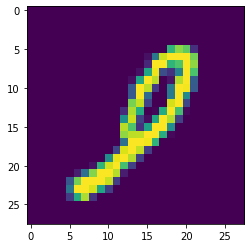

In [30]:
print("True", Y_val[665])
print("Predicted", y_pr[665])
plt.imshow(X_val[665][:,:,0])

True 4
Predicted 6


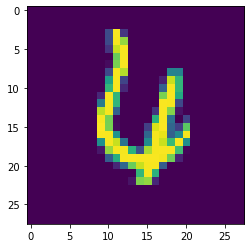

In [31]:
print("True", Y_val[725])
print("Predicted", y_pr[725])
plt.imshow(X_val[725][:,:,0])

## Сохранение результатов для публикации

In [14]:
y_pr = model.predict(test)

In [ ]:
results = np.argmax(y_pr,axis = 1)

results = pd.Series(results,name="Label")

submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("../content/drive/MyDrive/Machine/cnn_mnist_submission.csv",index=False)